In [1]:
# Imports

import os
import json
import tqdm
import yaml

import torch
import numpy as np
import matplotlib.pyplot as plt

from omegaconf import OmegaConf
from pathlib import Path
from tqdm.auto import tqdm

/mnt/stud/home/ynagel/dal-toolbox/venv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#%%bash
#fusermount -uz /mnt/work/dhuseljic
#sshfs cluster.ies:/mnt/work/dhuseljic/ /mnt/work/dhuseljic

In [4]:
def load_json(json_file):
    with open(json_file, 'r') as f:
        data = json.load(f)
    return data

def load_results(path):
    path = Path(path)
    assert path.is_dir(), 'Path does not exist.'
        
    results = {}

    exp_json = path / 'results.json'
    exp_cfg = path / '.hydra' / 'config.yaml'
    exp_checkpoint = path / 'model_final.pth'

    if exp_cfg.is_file():
        cfg =  OmegaConf.load(exp_cfg)
        results['cfg'] = cfg
    else:
        raise ValueError(f'Config missing for {exp_cfg}')

    if exp_json.is_file():
        data = load_json(exp_json)
        results['results'] = data
    else:
        raise ValueError(f'Results missing for {exp_json}')

    return results

def get_experiments(result_path, glob_pattern, train_results=False):
    # Aggregate results over multiple glob pattern such as seeds
    experiments = []
    print('Searching in', result_path)
    for exp_path in result_path.glob(glob_pattern):
        print('> Found', exp_path.name)
        d = load_results(exp_path)
        experiments.append(d)
    assert len(experiments) != 0, f'No experiments found for {result_path}.'
    return experiments

path = f'/mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}/'
exp_results = get_experiments(Path(path), 'seed1')
print(exp_results[0]['results']['cycle0'].keys())
print(exp_results[0]['results']['cycle0']['test_stats'].keys())

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed1
dict_keys(['test_stats', 'labeled_indices', 'n_labeled_samples', 'unlabeled_indices', 'n_unlabeled_samples'])
dict_keys(['accuracy', 'nll', 'brier', 'tce', 'ace'])


## Aleatoric Results

In [5]:
root_path = Path('/mnt/stud/home/ynagel/dal-toolbox/results/udal/')
dataset = 'CIFAR100'
model = 'resnet18'
experiments = {}
num_cycles = 38
# Deterministic
experiments.update({
    'random':  root_path / f'active_learning/{dataset}/resnet18/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'lc':      root_path / f'active_learning/{dataset}/resnet18/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'margin':  root_path / f'active_learning/{dataset}/resnet18/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'entropy': root_path / f'active_learning/{dataset}/resnet18/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    
    # 'random eval':  root_path / f'active_learning/{dataset}/resnet18/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'lc eval':      root_path / f'active_learning/{dataset}/resnet18/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'margin eval':  root_path / f'active_learning/{dataset}/resnet18/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'entropy eval': root_path / f'active_learning/{dataset}/resnet18/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
})

# # Labels smoothing
experiments.update({
    'random (ls)':  root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'lc (ls)':      root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'margin (ls)':  root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'entropy (ls)': root_path / f'active_learning/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',

    # 'random (ls) eval':     root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'lc (ls) eval':         root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'margin (ls) eval':     root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'entropy (ls) eval':    root_path / f'evaluation/{dataset}/resnet18_labelsmoothing/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
})
# 
# Mixup
experiments.update({
    'random (mixup)':   root_path / f'active_learning/{dataset}/resnet18_mixup/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'lc (mixup)':       root_path / f'active_learning/{dataset}/resnet18_mixup/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'margin (mixup)':   root_path / f'active_learning/{dataset}/resnet18_mixup/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    'entropy (mixup)':  root_path / f'active_learning/{dataset}/resnet18_mixup/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',

    # 'random (mixup) eval':  root_path / f'evaluation/{dataset}/resnet18_mixup/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'lc (mixup) eval':      root_path / f'evaluation/{dataset}/resnet18_mixup/least_confident/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'margin (mixup) eval':  root_path / f'evaluation/{dataset}/resnet18_mixup/margin/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
    # 'entropy (mixup) eval': root_path / f'evaluation/{dataset}/resnet18_mixup/entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{num_cycles}/',
})


all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

  0%|          | 0/12 [00:00<?, ?it/s]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed9
> Found seed3
> Found seed4
> Found seed10
> Found seed7
> Found seed5
> Found seed2
> Found seed8
> Found seed6


  8%|▊         | 1/12 [00:05<00:57,  5.22s/it]

> Found seed1
Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed4
> Found seed9
> Found seed3
> Found seed7
> Found seed2
> Found seed8
> Found seed10
> Found seed5
> Found seed1
> Found seed6


 17%|█▋        | 2/12 [00:11<00:58,  5.89s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed6
> Found seed1
> Found seed5
> Found seed8
> Found seed2
> Found seed7
> Found seed10
> Found seed3
> Found seed9
> Found seed4


 25%|██▌       | 3/12 [00:18<00:55,  6.20s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed10
> Found seed9
> Found seed3
> Found seed4
> Found seed7
> Found seed5
> Found seed2
> Found seed8
> Found seed6
> Found seed1


 33%|███▎      | 4/12 [00:23<00:46,  5.81s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18_labelsmoothing/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed1
> Found seed6
> Found seed2
> Found seed8
> Found seed10
> Found seed5
> Found seed7
> Found seed4
> Found seed9
> Found seed3


 42%|████▏     | 5/12 [00:30<00:43,  6.18s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18_labelsmoothing/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed8
> Found seed2
> Found seed5
> Found seed1
> Found seed10
> Found seed6
> Found seed4
> Found seed3
> Found seed9
> Found seed7


 50%|█████     | 6/12 [00:37<00:38,  6.45s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18_labelsmoothing/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed7
> Found seed10
> Found seed4
> Found seed9
> Found seed3
> Found seed1
> Found seed6
> Found seed2
> Found seed8
> Found seed5


 58%|█████▊    | 7/12 [00:43<00:31,  6.28s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18_labelsmoothing/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed6
> Found seed1
> Found seed5
> Found seed8
> Found seed2
> Found seed7
> Found seed3
> Found seed9
> Found seed10
> Found seed4


 67%|██████▋   | 8/12 [00:48<00:24,  6.10s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18_mixup/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed6
> Found seed1
> Found seed5
> Found seed2
> Found seed10
> Found seed8
> Found seed7
> Found seed9
> Found seed3
> Found seed4


 75%|███████▌  | 9/12 [00:56<00:19,  6.54s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18_mixup/least_confident/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed7
> Found seed3
> Found seed9
> Found seed4
> Found seed6
> Found seed10
> Found seed1
> Found seed5
> Found seed8
> Found seed2


 83%|████████▎ | 10/12 [01:03<00:13,  6.64s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18_mixup/margin/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed7
> Found seed3
> Found seed9
> Found seed4
> Found seed6
> Found seed1
> Found seed10
> Found seed5
> Found seed8
> Found seed2


 92%|█████████▏| 11/12 [01:08<00:06,  6.15s/it]

Searching in /mnt/stud/home/ynagel/dal-toolbox/results/udal/active_learning/CIFAR100/resnet18_mixup/entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed3
> Found seed9
> Found seed4
> Found seed7
> Found seed5
> Found seed8
> Found seed2
> Found seed6
> Found seed1
> Found seed10


100%|██████████| 12/12 [01:14<00:00,  6.19s/it]


100%|██████████| 12/12 [00:00<00:00, 49.61it/s]


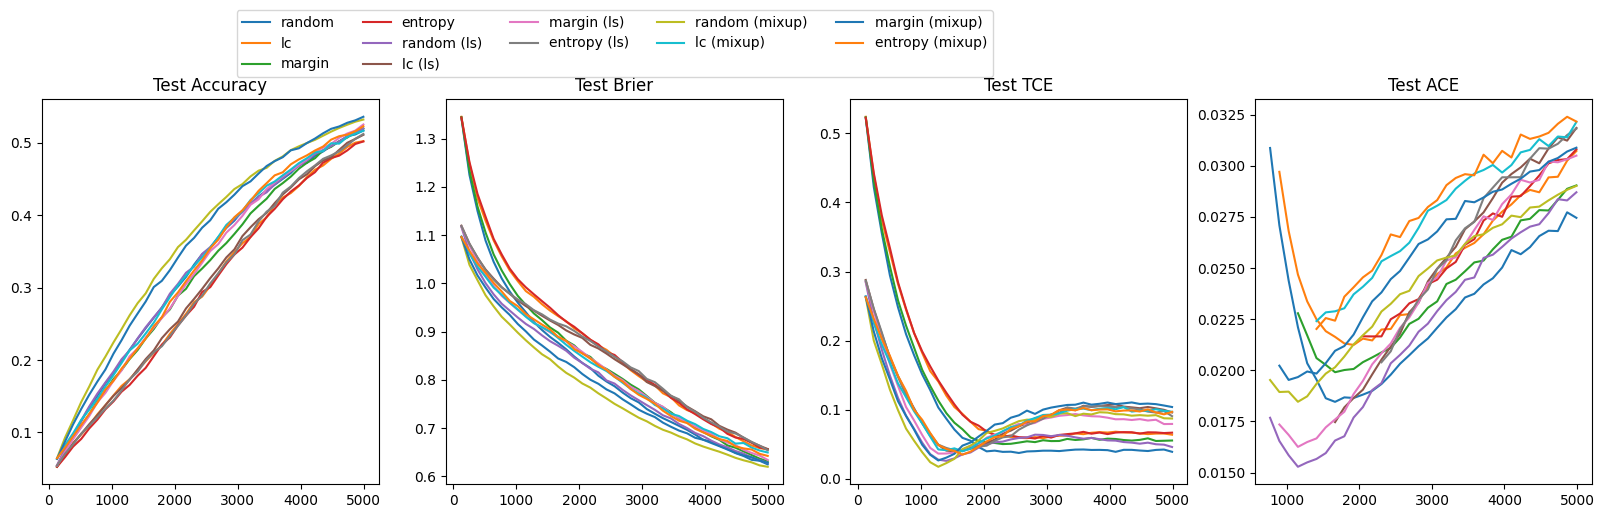

In [6]:
show_std = False
table_dict = {}
plt.figure(figsize=(20, 5))
for strat_name, results in tqdm(all_results.items()):

    train_accs = []
    train_loss = []
    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_ace = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']
        # print(strat_name, data['cycle0']['labeled_indices'])

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        # train_accs.append([data[cycle]['train_history'][-1]['train_acc1'] for cycle in data])
        # train_loss.append([data[cycle]['train_history'][-1]['train_loss'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_ace.append([data[cycle]['test_stats']['ace'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    # train_accs_mean, train_accs_std = np.mean(train_accs, 0), np.std(train_accs, 0)
    # train_loss_mean, train_loss_std = np.mean(train_loss, 0), np.std(train_loss, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_ace_mean, test_ace_std = np.mean(test_ace, 0), np.std(test_ace, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'nll (Final)': test_nll_mean[-1], 
        'nll (AUC)': np.mean(test_nll_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1],
        'TCE (AUC)': np.mean(test_tce_mean), 
        'ACE (Final)': test_ace_mean[-1],
        'ACE (AUC)': np.mean(test_ace_mean), 
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test ACE')
    plt.plot(n_labeled_samples, test_ace_mean, '-', label=strat_name)
    if show_std:
        plt.fill_between(n_labeled_samples, test_ace_mean-test_ace_std, test_ace_mean+test_ace_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=5)
        

In [7]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict).T
print(df.to_latex(float_format="%.3f"))
print(df.to_markdown(tablefmt='github'))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & nll (Final) & nll (AUC) & brier (Final) & brier (AUC) & TCE (Final) & TCE (AUC) & ACE (Final) & ACE (AUC) \\
\midrule
random & 0.517 & 0.332 & 2.032 & 3.137 & 0.625 & 0.826 & 0.039 & 0.100 & 0.027 & NaN \\
lc & 0.502 & 0.299 & 2.088 & 3.324 & 0.656 & 0.872 & 0.064 & 0.126 & 0.031 & NaN \\
margin & 0.520 & 0.323 & 2.003 & 3.180 & 0.631 & 0.843 & 0.056 & 0.113 & 0.029 & NaN \\
entropy & 0.502 & 0.296 & 2.100 & 3.352 & 0.656 & 0.874 & 0.067 & 0.127 & 0.031 & NaN \\
random (ls) & 0.520 & 0.333 & 2.100 & 3.048 & 0.628 & 0.807 & 0.046 & 0.071 & 0.029 & NaN \\
lc (ls) & 0.511 & 0.304 & 2.159 & 3.218 & 0.656 & 0.847 & 0.096 & 0.100 & 0.032 & NaN \\
margin (ls) & 0.525 & 0.327 & 2.079 & 3.086 & 0.634 & 0.822 & 0.080 & 0.092 & 0.030 & NaN \\
entropy (ls) & 0.512 & 0.301 & 2.155 & 3.235 & 0.654 & 0.849 & 0.091 & 0.099 & 0.032 & NaN \\
random (mixup) & 0.532 & 0.367 & 2.021 & 2.886 & 0.620 & 0.778 & 0.087 & 0.087 & 0.029 & NaN \\
l

ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [ ]:
df1 = df[['nll (AUC)', 'brier (AUC)', 'TCE (AUC)', 'ACE (AUC)']]
print(df1.to_latex(float_format="%.3f"))

## Epistemic Results

In [5]:
root_path = Path('/mnt/work/dhuseljic/results/udal/')
dataset = 'CIFAR10'
experiments = {}

# MC-Dropout
experiments.update({
    # 'random (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}/',
    # 'entropy (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}/',
    # 'bald (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/bald/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}/',
    # 'varratio (MC-Dropout)': root_path / f'active_learning/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}/',

    #'random eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    #'entropy eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    #'bald eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    #'variation ratio eval (MC-Dropout)': f'results/evaluation/{dataset}/resnet18_mcdropout/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
})
# Ensemble
experiments.update({
    'random (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/random/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}/',
    'entropy (Ensemble)': root_path / f'active_learning/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{128}__ACQ_SIZE{128}__N_ACQ{38}/',

    # 'random eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/random/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'entropy eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/bayesian_entropy/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'bald (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'bald eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/bald/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'variation ratio (Ensemble)': f'results/active_learning/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
    # 'variation ratio eval (Ensemble)': f'results/evaluation/{dataset}/resnet18_ensemble/variation_ratio/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/',
})

all_results = {}
for exp_name, exp_path in tqdm(experiments.items()):
    all_results[exp_name] = get_experiments(Path(exp_path), 'seed*')

  0%|          | 0/2 [00:00<?, ?it/s]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_ensemble/random/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed1
> Found seed10
> Found seed6
> Found seed2
> Found seed8
> Found seed5
> Found seed7
> Found seed4
> Found seed9
> Found seed3


 50%|█████     | 1/2 [00:01<00:01,  1.66s/it]

Searching in /mnt/work/dhuseljic/results/udal/active_learning/CIFAR10/resnet18_ensemble/bayesian_entropy/N_INIT128__ACQ_SIZE128__N_ACQ38
> Found seed5
> Found seed2
> Found seed8
> Found seed10
> Found seed6
> Found seed1
> Found seed9
> Found seed3
> Found seed4
> Found seed7


100%|██████████| 2/2 [00:07<00:00,  3.82s/it]


100%|██████████| 2/2 [00:00<00:00, 16.07it/s]


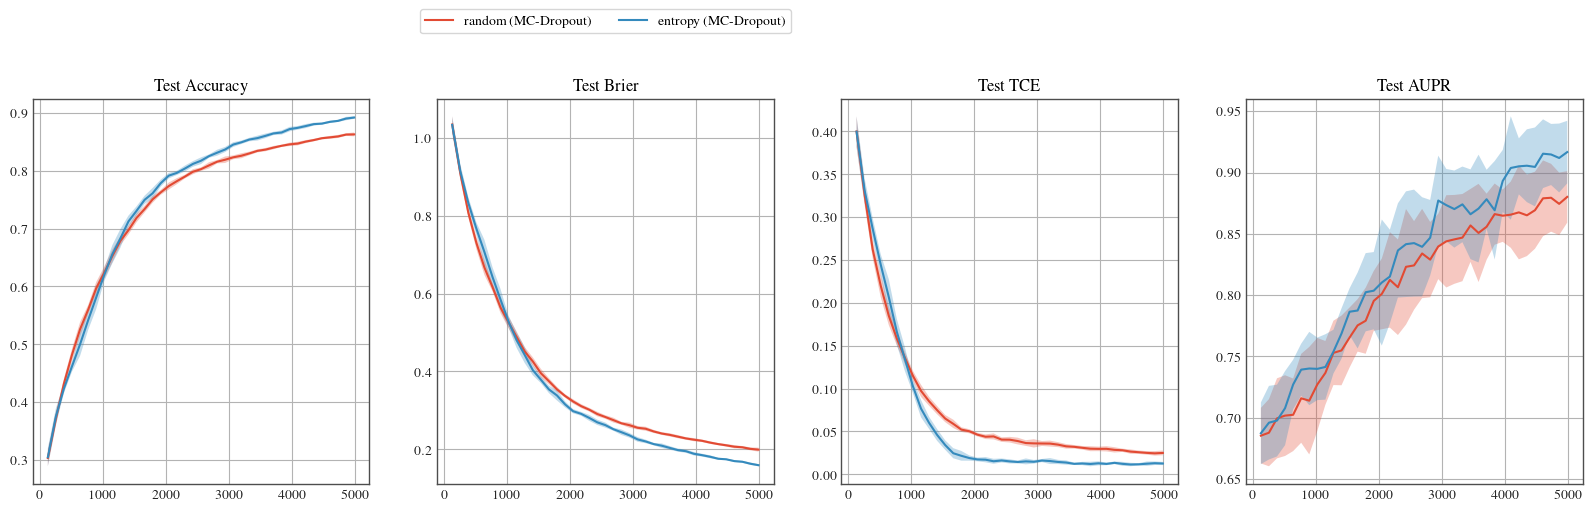

In [6]:
table_dict = {}
plt.figure(figsize=(20, 5))
show_std = True
for strat_name, results in tqdm(all_results.items()):

    test_accs = []
    test_nll = []
    test_brier = []
    test_tce = []
    test_aupr_cifar100 = []
    test_aupr_svhn = []
    n_labeled_samples = []
    for seed_result in results:
        data = seed_result['results']

        # Get metric values of interest
        n_labeled_samples.append([data[cycle]['n_labeled_samples'] for cycle in data])
        test_accs.append([data[cycle]['test_stats']['accuracy'] for cycle in data])
        test_nll.append([data[cycle]['test_stats']['nll'] for cycle in data])
        test_brier.append([data[cycle]['test_stats']['brier'] for cycle in data])
        test_tce.append([data[cycle]['test_stats']['tce'] for cycle in data])
        test_aupr_cifar100.append([data[cycle]['test_stats']['aupr_CIFAR100'] for cycle in data])
        test_aupr_svhn.append([data[cycle]['test_stats']['aupr_SVHN'] for cycle in data])

    n_labeled_samples = np.mean(n_labeled_samples, 0)
    test_accs_mean, test_accs_std = np.mean(test_accs, 0), np.std(test_accs, 0)
    test_nll_mean, test_nll_std = np.mean(test_nll, 0), np.std(test_nll, 0)
    test_brier_mean, test_brier_std = np.mean(test_brier, 0), np.std(test_brier, 0)
    test_tce_mean, test_tce_std = np.mean(test_tce, 0), np.std(test_tce, 0)
    test_aupr_svhn_mean, test_aupr_svhn_std = np.mean(test_aupr_svhn, 0), np.std(test_aupr_svhn, 0)
    test_aupr_cifar100_mean, test_aupr_cifar100_std = np.mean(test_aupr_cifar100, 0), np.std(test_aupr_cifar100, 0)

    table_dict[strat_name] = {
        'acc (Final)': test_accs_mean[-1], 
        'acc (AUC)': np.mean(test_accs_mean), 
        'brier (Final)': test_brier_mean[-1], 
        'brier (AUC)': np.mean(test_brier_mean), 
        'TCE (Final)': test_tce_mean[-1], 
        'TCE (AUC)': np.mean(test_tce_mean), 
        'AUPR CIFAR100 (Final)': test_aupr_cifar100_mean[-1],
        'AUPR CIFAR100 (AUC)': np.mean(test_aupr_cifar100_mean),
        'AUPR SVHN (Final)': test_aupr_svhn_mean[-1],
        'AUPR SVHN (AUC)': np.mean(test_aupr_svhn_mean),
    }

    plt.subplot(141)
    plt.title('Test Accuracy')
    plt.plot(n_labeled_samples, test_accs_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_accs_mean-test_accs_std, test_accs_mean+test_accs_std, alpha=.3)
    plt.subplot(142)
    plt.title('Test Brier')
    plt.plot(n_labeled_samples, test_brier_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_brier_mean-test_brier_std, test_brier_mean+test_brier_std, alpha=.3)
    plt.subplot(143)
    plt.title('Test TCE')
    plt.plot(n_labeled_samples, test_tce_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_tce_mean-test_tce_std, test_tce_mean+test_tce_std, alpha=.3)
    plt.subplot(144)
    plt.title('Test AUPR')
    plt.plot(n_labeled_samples, test_aupr_svhn_mean, '-', label=strat_name)
    plt.fill_between(n_labeled_samples, test_aupr_svhn_mean-test_aupr_svhn_std, test_aupr_svhn_mean+test_aupr_svhn_std, alpha=.3)
    # plt.plot(n_labeled_samples, test_aupr_svhn_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, test_aupr_svhn_mean-test_aupr_svhn_std, test_aupr_svhn_mean+test_aupr_svhn_std, alpha=.3)

    # plt.subplot(144)
    # plt.title('Train Loss')
    # plt.plot(n_labeled_samples, train_loss_mean, '-', label=strat_name)
    # plt.fill_between(n_labeled_samples, train_loss_mean-train_loss_std, train_loss_mean+train_loss_std, alpha=.3)

plt.subplot(142).legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=2)
        

In [7]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T.to_latex(float_format="%.3f"))

\begin{tabular}{lrrrrrrrrrr}
\toprule
 & acc (Final) & acc (AUC) & brier (Final) & brier (AUC) & TCE (Final) & TCE (AUC) & AUPR CIFAR100 (Final) & AUPR CIFAR100 (AUC) & AUPR SVHN (Final) & AUPR SVHN (AUC) \\
\midrule
random (MC-Dropout) & 0.864 & 0.739 & 0.199 & 0.374 & 0.025 & 0.079 & 0.783 & 0.706 & 0.880 & 0.804 \\
entropy (MC-Dropout) & 0.893 & 0.753 & 0.159 & 0.356 & 0.013 & 0.064 & 0.826 & 0.731 & 0.917 & 0.825 \\
\bottomrule
\end{tabular}



In [8]:
# Create Table
import pandas as pd
df = pd.DataFrame(table_dict)
print(df.T[['brier (AUC)', 'TCE (AUC)', 'AUPR CIFAR100 (AUC)', 'AUPR SVHN (AUC)']].to_latex(float_format="%.3f"))

\begin{tabular}{lrrrr}
\toprule
 & brier (AUC) & TCE (AUC) & AUPR CIFAR100 (AUC) & AUPR SVHN (AUC) \\
\midrule
random (MC-Dropout) & 0.374 & 0.079 & 0.706 & 0.804 \\
entropy (MC-Dropout) & 0.356 & 0.064 & 0.731 & 0.825 \\
\bottomrule
\end{tabular}



## Load Experiment

In [ ]:
import sys
sys.path.append('..')
from active_learning import build_datasets, build_model

model_name = 'resnet18_mcdropout'
strat_name = 'random'
exp_path = Path(f'results/active_learning/CIFAR10/{model_name}/{strat_name}/N_INIT{100}__ACQ_SIZE{100}__N_ACQ{19}/seed1')
checkpoint = torch.load(exp_path / 'checkpoint.pth')
args =  OmegaConf.load(exp_path / '.hydra' / 'config.yaml')

trainer = build_model(args, n_classes=10)
model = trainer.model
model.load_state_dict(checkpoint['model'])

args.dataset_path = '/datasets'
_, _, test_ds, _ = build_datasets(args)

2023-05-02 22:12:41.242831: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-02 22:12:41.894472: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
results = load_json(exp_path / 'results.json')
results['cycle19']['test_stats']

{'test_acc1': 72.94999694824219,
 'test_loss': 0.9619036912918091,
 'test_nll': 0.8499259948730469,
 'test_brier': 0.38014087080955505,
 'test_tce': 0.06486481428146362,
 'test_mce': 0.036187052726745605,
 'test_CIFAR100_auroc': 0.7402122050000001,
 'test_CIFAR100_aupr': 0.6967468314841072,
 'test_SVHN_auroc': 0.7186415776736323,
 'test_SVHN_aupr': 0.8092618874912202}

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

logits_list = []
targets_list = []
model.cuda()
model.eval()
for inputs, targets in test_loader:
    with torch.no_grad():
        logits = model(inputs.cuda())
    logits_list.append(logits.cpu())
    targets_list.append(targets.cpu())

logits = torch.cat(logits_list)
targets = torch.cat(targets_list)

AttributeError: 'DropoutResNet18' object has no attribute 'forward_sample'

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)
probas = model.get_probas(test_loader, device='cuda').mean(1)
logits = probas.log()

In [ ]:
from dal_toolbox.metrics.calibration import ExpectedCalibrationError, TopLabelCalibrationError, AdaptiveCalibrationError
from torchmetrics.classification import Accuracy

acc_fn = Accuracy()
print('Accuracy: {}'.format(acc_fn(logits, targets)))
tce_fn = TopLabelCalibrationError(n_bins=15)
print('ECE: {}'.format(tce_fn(logits.softmax(-1), targets)))
ace_fn = AdaptiveCalibrationError()
print('ACE: {}'.format(ace_fn(logits.softmax(-1), targets)))
plt.figure(figsize=(5, 5))
plt.plot(tce_fn.results['confs'], tce_fn.results['accs'], '-o', linewidth=2)
plt.plot([0, 1], [0, 1], linewidth=3, linestyle=':')
plt.twinx()
plt.grid()
bar_x = [conf for conf in tce_fn.results['confs'] if not np.isnan(conf)]
bar_y = [n for n in tce_fn.results['n_samples'] if n != 0]
plt.bar(bar_x, bar_y, width=.05, alpha=.3)
plt.tight_layout()
plt.savefig(f'plots_al/cal-plot_{model_name}_{strat_name}.pdf')
plt.show()

ValueError: The `preds` and `target` should have the same first dimension.

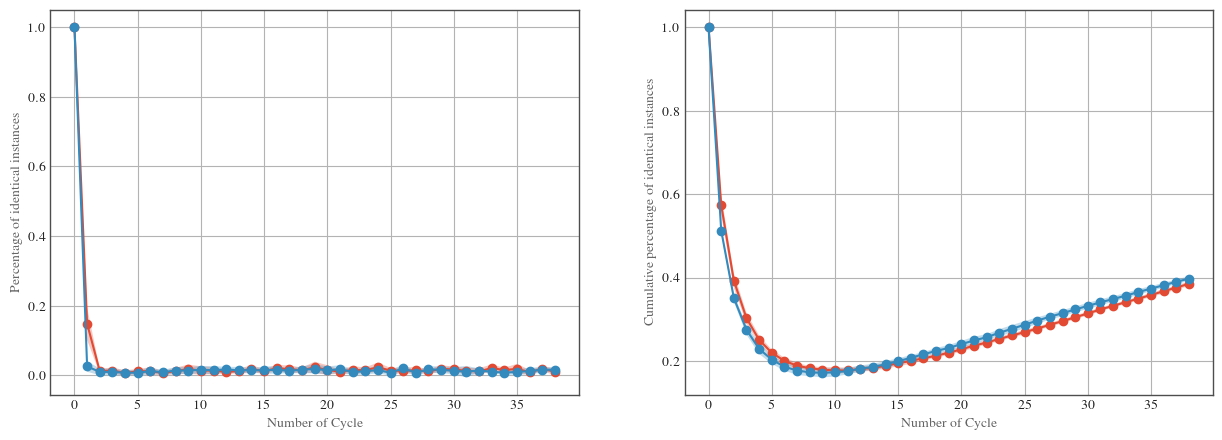

In [71]:
plt.figure(figsize=(15, 5))

for method in ['ls', 'mixup']:

    buy_agreement_list = []
    cum_buy_agreement_list = []

    for i_seed in range(1, 11):
        dir1 = experiments['entropy eval']
        json1 = dir1 / f'seed{i_seed}' / 'queried_indices.json'
        queried_indices1 = load_json(json1)

        dir2 = experiments[f'entropy ({method})']
        json2 = dir2 / f'seed{i_seed}' / 'queried_indices.json'
        queried_indices2 = load_json(json2)

        indices1 = []
        indices2 = []

        buy_agreement = []
        cumulative_buy_agreement = []

        for key in queried_indices1:
            q_indices1 = queried_indices1[key]
            q_indices2 = queried_indices2[key]
            indices1.extend(q_indices1)
            indices2.extend(q_indices2)

            buy_agreement.append(np.isin(q_indices1, q_indices2).mean())
            cumulative_buy_agreement.append((np.isin(indices1, indices2).mean()))

        buy_agreement_list.append(buy_agreement)
        cum_buy_agreement_list.append(cumulative_buy_agreement)

    buy_agreement_mean = np.mean(buy_agreement_list, axis=0)
    buy_agreement_std = np.std(buy_agreement_list, axis=0)
    cum_buy_agreement_mean = np.mean(cum_buy_agreement_list, axis=0)
    cum_buy_agreement_std = np.std(cum_buy_agreement_list, axis=0)

    plt.subplot(121)
    plt.plot(buy_agreement_mean, '-o')
    plt.fill_between(range(len(buy_agreement_mean)), buy_agreement_mean+buy_agreement_std, buy_agreement_mean-buy_agreement_std, alpha=.3)
    plt.xlabel('Number of Cycle')
    plt.ylabel('Percentage of identical instances')

    plt.subplot(122)
    plt.plot(cum_buy_agreement_mean, '-o')

    plt.fill_between(range(len(cum_buy_agreement_mean)), cum_buy_agreement_mean+cum_buy_agreement_std, cum_buy_agreement_mean-cum_buy_agreement_std, alpha=.3)
    plt.xlabel('Number of Cycle')
    plt.ylabel('Cumulative percentage of identical instances')

plt.show()

In [60]:
buy_agreement_list[0]
buy_agreement_list[1]

[1.0,
 0.03125,
 0.0,
 0.015625,
 0.0,
 0.0234375,
 0.0,
 0.0078125,
 0.015625,
 0.0,
 0.0234375,
 0.0390625,
 0.015625,
 0.0234375,
 0.015625,
 0.0390625,
 0.0234375,
 0.0078125,
 0.03125,
 0.03125,
 0.0390625,
 0.015625,
 0.015625,
 0.015625,
 0.0078125,
 0.0,
 0.0078125,
 0.015625,
 0.015625,
 0.0234375,
 0.015625,
 0.0234375,
 0.0234375,
 0.015625,
 0.0,
 0.015625,
 0.015625,
 0.015625,
 0.015625]

10


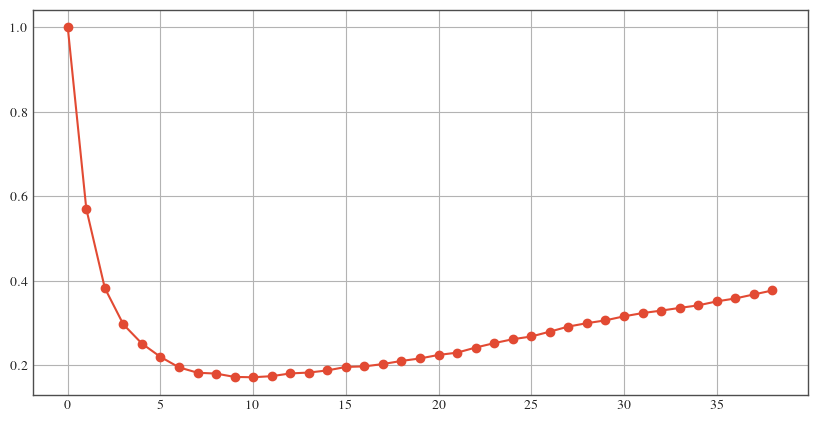

In [97]:
print(i_seed)
dir1 = experiments['entropy eval']
json1 = dir1 / f'seed{i_seed}' / 'results.json'
results1 = load_json(json1)

dir2 = experiments['entropy (ls) eval']
json2 = dir2 / f'seed{i_seed}' / 'results.json'
results2 = load_json(json2)

cum_buy_agreement = []
for key in results1:
    cum_buy_agreement.append(np.isin(results1[key]['labeled_indices'], results2[key]['labeled_indices']).mean())
plt.plot(cum_buy_agreement, '-o')

10


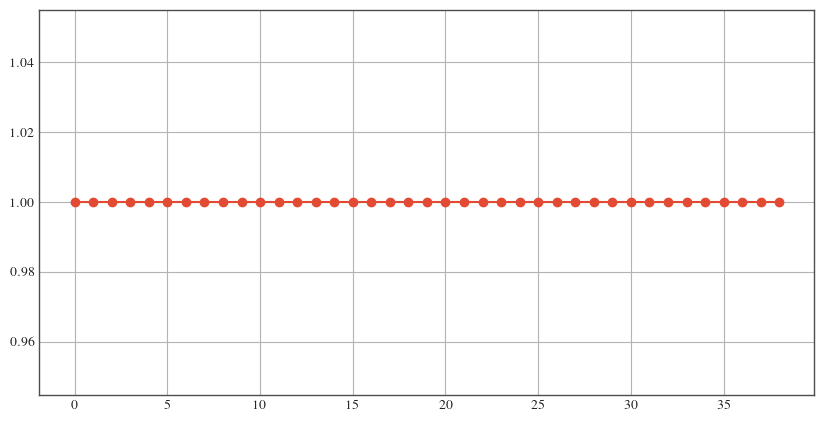

In [98]:
print(i_seed)
dir1 = experiments['entropy (ls)']
json1 = dir1 / f'seed{i_seed}' / 'queried_indices.json'
queried_indices1 = load_json(json1)

dir2 = experiments['entropy (ls) eval']
json2 = dir2 / f'seed{i_seed}' / 'results.json'
results2 = load_json(json2)

cum_buy_agreement = []
for key in results1:
    cum_buy_agreement.append(np.isin(queried_indices1[key], results2[key]['labeled_indices']).mean())
plt.plot(cum_buy_agreement, '-o')